In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path as path
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout, BatchNormalization

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score,classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Read The Data 

In [3]:
pneumonia_path = path(r"/content/drive/MyDrive/Chest X_Ray/train/PNEUMONIA")

In [4]:
pneumonia_images = os.listdir(r"/content/drive/MyDrive/Chest X_Ray/train/PNEUMONIA")

In [5]:
len(pneumonia_images)

3875

In [6]:
pneumonia_filepaths = [str(pneumonia_path) + '/' + img_path for img_path in pneumonia_images]
pneumonia_filepaths=pneumonia_filepaths[:2000]
len(pneumonia_filepaths)

2000

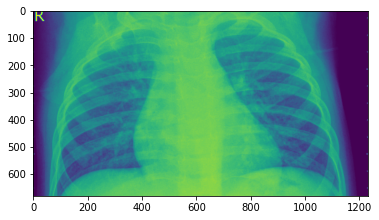

In [7]:
# all images file paths
img = plt.imread(pneumonia_filepaths[8])
plt.imshow(img)
plt.show()

In [8]:
normal_path = path(r"/content/drive/MyDrive/Chest X_Ray/train/NORMAL")
normal_images = os.listdir(r"/content/drive/MyDrive/Chest X_Ray/train/NORMAL")

In [9]:
len(normal_images)

1341

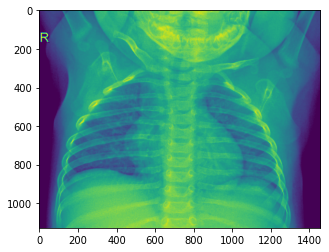

In [10]:
img = plt.imread(str(normal_path)+'/'+normal_images[10])
plt.imshow(img)
plt.show()

In [11]:
normal_filespaths = [str(normal_path) + '/' + img_path for img_path in normal_images]
#normal_filespaths=normal_filespaths[500:1000]

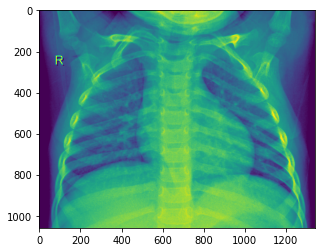

In [12]:
img = plt.imread(normal_filespaths[2])
plt.imshow(img)
plt.show()

# Pre_Processing

In [13]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [14]:
pneumonia_df = proc_img(pneumonia_filepaths)
pneumonia_df.head(1)

,Filepath,Label
0,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA


In [15]:
normal_df = proc_img(normal_filespaths)
normal_df.head(1)

,Filepath,Label
0,/content/drive/MyDrive/Chest X_Ray/train/NORMA...,NORMAL


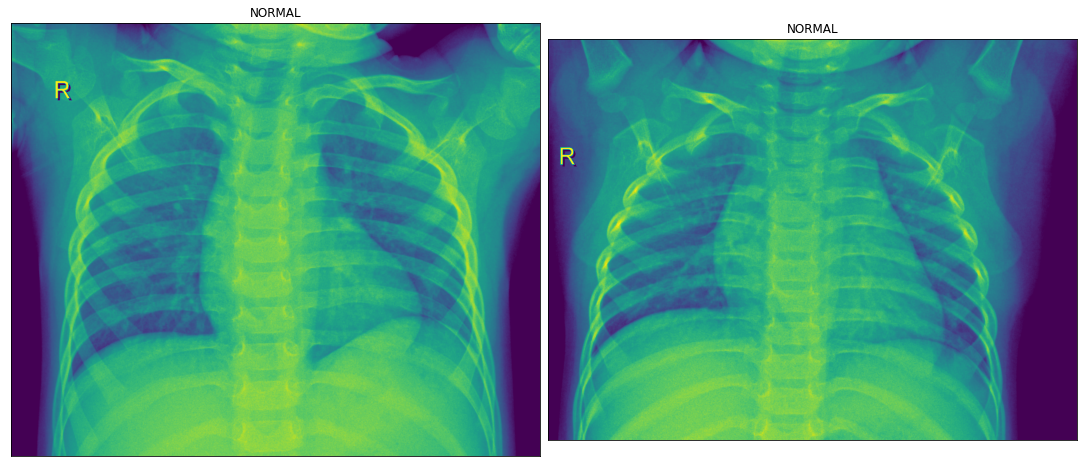

In [16]:
# Display 2 picture of the Normal dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(normal_df.Filepath[i]))
    ax.set_title(normal_df.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

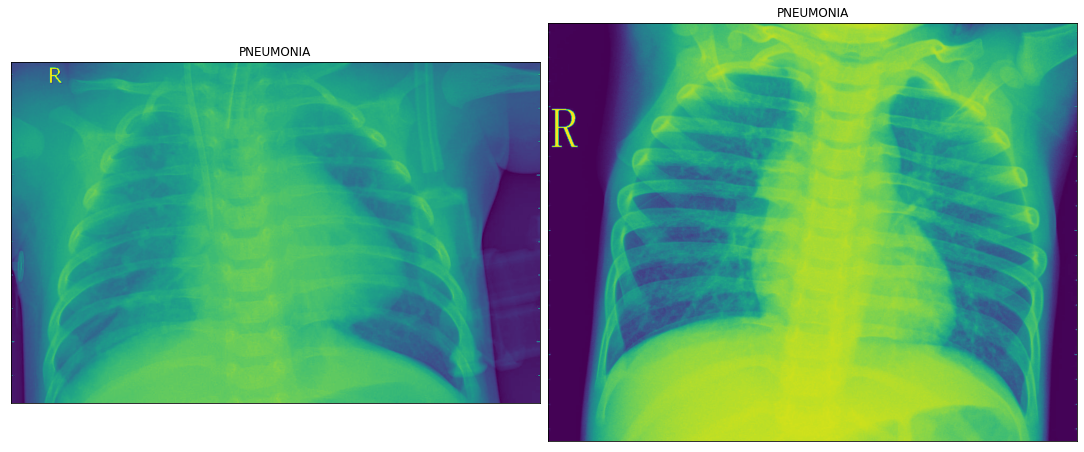

In [17]:
# Display 2 picture of the Covid dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(pneumonia_df.Filepath[i]))
    ax.set_title(pneumonia_df.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

In [18]:
# Concat the two data frame(covid and normal)
pneumonia_normal_data = pd.concat([pneumonia_df, normal_df], axis=0)

In [19]:
pneumonia_normal_data.sample(10)

,Filepath,Label
312,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
91,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
87,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
442,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
1314,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
348,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
325,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
429,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
669,/content/drive/MyDrive/Chest X_Ray/train/NORMA...,NORMAL
291,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA


In [20]:
pneumonia_normal_data.shape

(3341, 2)

In [21]:
pneumonia_normal_data['Label'].value_counts()

PNEUMONIA    2000
NORMAL       1341
Name: Label, dtype: int64

__Train Test Split__

In [22]:
# Take a .2 sample from the data frame
int(len(pneumonia_normal_data) * 0.25)    #  num of test images

835

In [23]:
# Test_dataframe
test_data = pneumonia_normal_data.sample(n=450,random_state=42)
test_data.Label.value_counts()

PNEUMONIA    304
NORMAL       146
Name: Label, dtype: int64

In [24]:
# Find Rows in df Which Are Not Available in test_df
train_data = pneumonia_normal_data.merge(test_data, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']

In [25]:
train_data.Label.value_counts()

PNEUMONIA    1696
NORMAL       1195
Name: Label, dtype: int64

In [26]:
len(train_data.Label)

2891

# Image Generator

In [27]:
# Train generator
train_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)


train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2891 validated image filenames belonging to 2 classes.


In [28]:
# Test generator
test_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 450 validated image filenames belonging to 2 classes.


# Model 

In [29]:
model= Sequential()

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(120,120,1,)))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(Dropout(0.4))

model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation = 'softmax'))  # the output layer

In [30]:
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

__Model Summary__

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 116, 116, 30)      8670      
_________________________________________________________________
dropout (Dropout)            (None, 116, 116, 30)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 58, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 30)        8130      
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 30)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 30)        0

__Early Stop__

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [33]:
model.fit(train_images, epochs = 6 , validation_data = test_images, verbose=1, callbacks=early_stop)

Epoch 1/6
91/91 [==============================] - 732s 8s/step - loss: 0.6845 - accuracy: 0.5866 - val_loss: 0.6682 - val_accuracy: 0.6756
Epoch 2/6
91/91 [==============================] - 166s 2s/step - loss: 0.6804 - accuracy: 0.5866 - val_loss: 0.6442 - val_accuracy: 0.6756
Epoch 3/6
91/91 [==============================] - 167s 2s/step - loss: 0.6799 - accuracy: 0.5866 - val_loss: 0.6557 - val_accuracy: 0.6756
Epoch 4/6
91/91 [==============================] - 169s 2s/step - loss: 0.6777 - accuracy: 0.5866 - val_loss: 0.6355 - val_accuracy: 0.6756
Epoch 5/6
91/91 [==============================] - 169s 2s/step - loss: 0.6796 - accuracy: 0.5866 - val_loss: 0.6493 - val_accuracy: 0.6756
Epoch 6/6
91/91 [==============================] - 169s 2s/step - loss: 0.6785 - accuracy: 0.5866 - val_loss: 0.6467 - val_accuracy: 0.6756


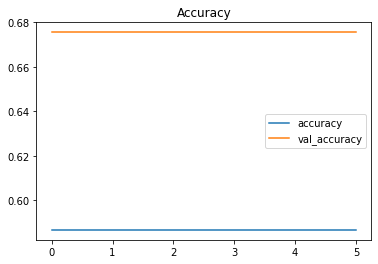

In [34]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy") 
plt.show()    

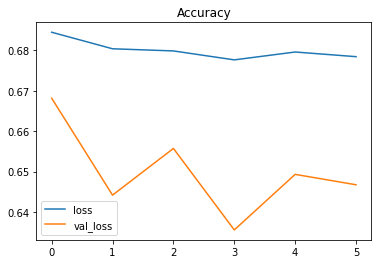

In [35]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()
plt.title("Accuracy") 
plt.show()  

__Prediction__

In [36]:
test_data.head()

,Filepath,Label
479,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
78,/content/drive/MyDrive/Chest X_Ray/train/NORMA...,NORMAL
705,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
1330,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
1606,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA


In [37]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA']


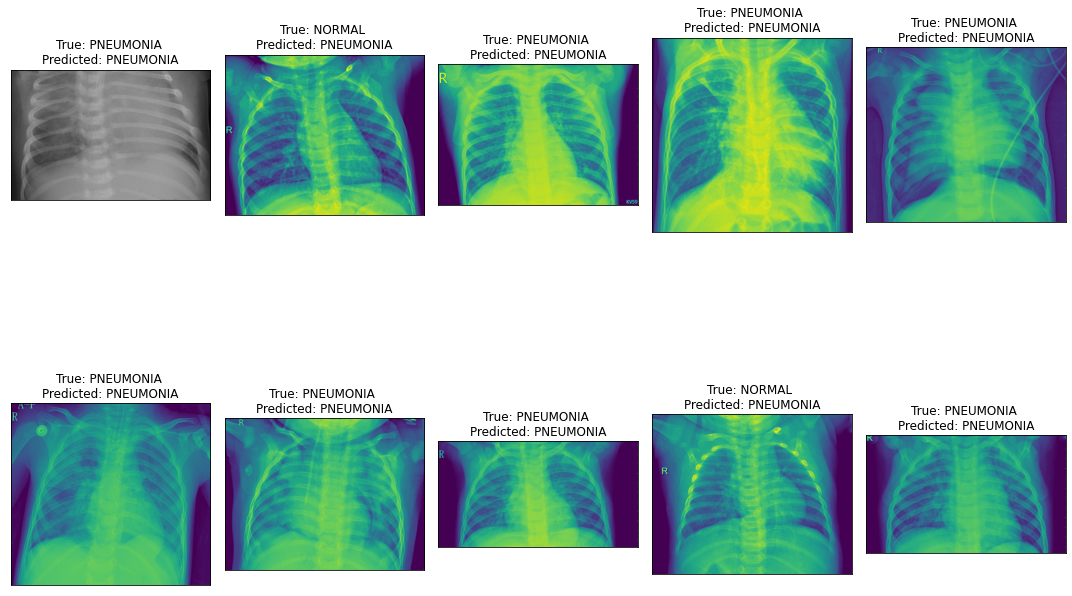

In [38]:
# Display 10 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_data.Filepath.iloc[i]))
    ax.set_title(f"True: {test_data.Label.iloc[i].split('_')[0]} \nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()

In [39]:

le = LabelEncoder()
# le.fit_transform(df[column])

test_labels = le.fit_transform(test_data.Label)
pred = le.fit_transform(pred)

In [40]:
confusion_matrix = pd.crosstab(test_labels, pred, rownames=['Actual'], colnames=['Predicted'], margins = True)
confusion_matrix

Predicted,0,All
Actual,,
0,146,146
1,304,304
All,450,450


# Im_Balanced Data

In [41]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


__under-sample model__

In [42]:
# reduce the majority rows to be equals the miniority one
undersample = RandomUnderSampler(sampling_strategy='majority')

In [43]:
pneumonia_normal_data.head()

,Filepath,Label
0,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
1,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
2,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
3,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA
4,/content/drive/MyDrive/Chest X_Ray/train/PNEUM...,PNEUMONIA


In [44]:
X = pneumonia_normal_data.iloc[:, :1].values

In [45]:
X.shape

(3341, 1)

In [46]:
y = pneumonia_normal_data.iloc[:, 1]

In [47]:
X, y = undersample.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [48]:
X[1]

array(['/content/drive/MyDrive/Chest X_Ray/train/NORMAL/IM-0729-0001.jpeg'],
      dtype=object)

In [49]:
X.shape

(2682, 1)

In [50]:
y[1]

'NORMAL'

In [51]:
y.shape

(2682,)

In [52]:
# Data Frame must be 1-D
X = X.reshape((2682, ))

In [53]:
# to check
from collections import Counter

In [54]:
print(Counter(y))

Counter({'NORMAL': 1341, 'PNEUMONIA': 1341})


In [55]:
balanced_df = pd.DataFrame({'Filepath': X, 'Label': y})

In [56]:
balanced_df.head()

,Filepath,Label
0,/content/drive/MyDrive/Chest X_Ray/train/NORMA...,NORMAL
1,/content/drive/MyDrive/Chest X_Ray/train/NORMA...,NORMAL
2,/content/drive/MyDrive/Chest X_Ray/train/NORMA...,NORMAL
3,/content/drive/MyDrive/Chest X_Ray/train/NORMA...,NORMAL
4,/content/drive/MyDrive/Chest X_Ray/train/NORMA...,NORMAL


In [57]:
balanced_df.Label.value_counts()

PNEUMONIA    1341
NORMAL       1341
Name: Label, dtype: int64

In [58]:
balanced_df.duplicated().sum()

0

__Train Test Split__

In [59]:
# Take a .2 sample from the data frame
int(len(balanced_df) * 0.2)    #  >> num of test images

536

In [60]:
# Test_df
test_df = balanced_df.sample(n=184,random_state=42)
test_df.Label.value_counts()

PNEUMONIA    93
NORMAL       91
Name: Label, dtype: int64

In [61]:
# Find Rows in balanced_df Which Are Not Available in test_df
train_df = balanced_df.merge(test_df, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']

In [62]:
train_df.Label.value_counts()

NORMAL       1250
PNEUMONIA    1248
Name: Label, dtype: int64

In [63]:
# Image Generator

In [64]:
# Train generator
train_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2498 validated image filenames belonging to 2 classes.


In [65]:
# Test generator
test_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 184 validated image filenames belonging to 2 classes.


# Model

In [66]:
model= Sequential()

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(120,120,1,)))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=32,kernel_size = (3,3),activation='relu'))

model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=32,kernel_size = (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(2,activation = 'softmax'))  # the output layer

In [67]:
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

__Model Summary__

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 118, 118, 32)      320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 116, 116, 30)      8670      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 58, 30)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 32)        8672      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)            

__Early Stop__

In [69]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [70]:
model.fit(train_images, epochs = 30 , validation_data = test_images, verbose=1, callbacks=early_stop)

Epoch 1/30
79/79 [==============================] - 138s 2s/step - loss: 0.6934 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4946
Epoch 2/30
79/79 [==============================] - 135s 2s/step - loss: 0.6933 - accuracy: 0.4828 - val_loss: 0.6933 - val_accuracy: 0.4946
Epoch 3/30
79/79 [==============================] - 135s 2s/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.4946
Epoch 4/30
79/79 [==============================] - 135s 2s/step - loss: 0.6933 - accuracy: 0.4924 - val_loss: 0.6932 - val_accuracy: 0.4946
Epoch 5/30
79/79 [==============================] - 134s 2s/step - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5054
Epoch 6/30
79/79 [==============================] - 134s 2s/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5054
Epoch 7/30
79/79 [==============================] - 133s 2s/step - loss: 0.6932 - accuracy: 0.4868 - val_loss: 0.6931 - val_accuracy: 0.5054
Epoch 8/30
79

__Visualize the output__

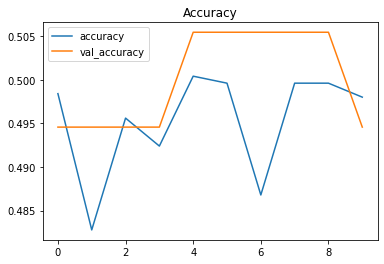

In [71]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy") 
plt.show()                  

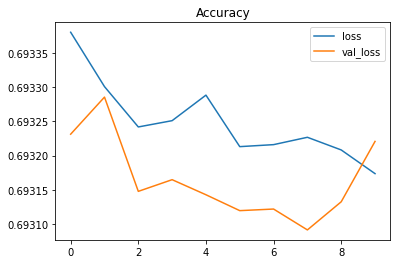

In [72]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()
plt.title("Accuracy") 
plt.show()      

# Prediction

In [73]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA']


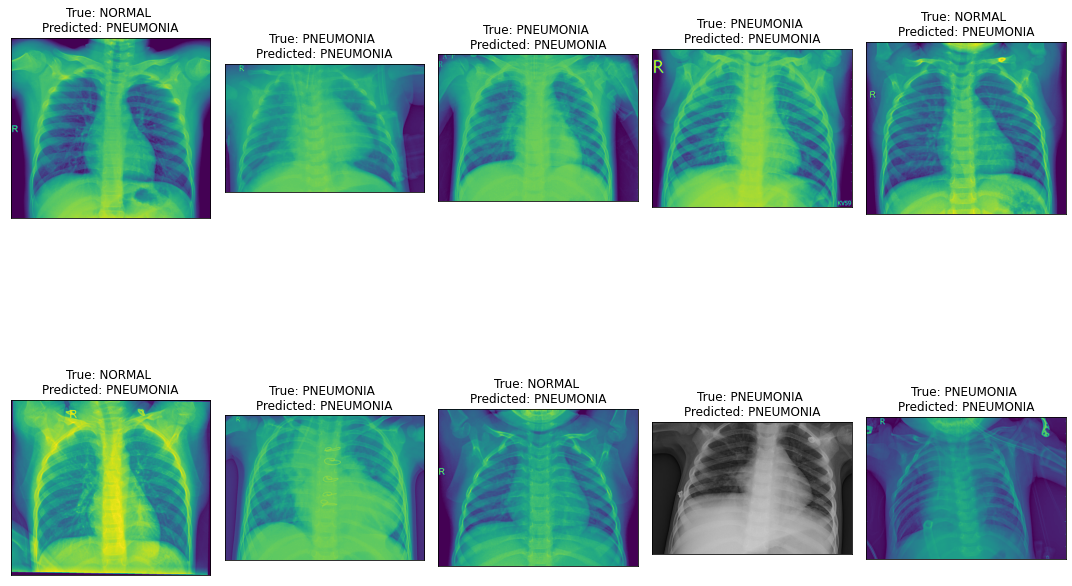

In [74]:
# Display 5 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow( plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]} \nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()

In [75]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 50.54%


__Apply Equalize_Histogram__

In [76]:
import cv2 as cv

In [77]:
def LoadImages(column):
    path_list = []
    for i in range(len(column)):
        try:
            path_list.append(cv.resize(cv.imread(column.loc[i], 0), (150, 150)))
        except:
            continue

    return np.array(path_list)

In [78]:
test_images = []
test_images = LoadImages(test_df.Filepath)

In [79]:
train_images = []
train_images = LoadImages(train_df.Filepath)

In [80]:
train_images.shape

(2331, 150, 150)

In [81]:
test_images.shape

(14, 150, 150)

In [82]:
from skimage.exposure import equalize_hist
from skimage import color
from tensorflow.keras.utils import to_categorical

In [83]:
for i in range(train_images.shape[0]):
    train_images[i] = equalize_hist(train_images[i])

In [84]:
for i in range(test_images.shape[0]):
    test_images[i] = equalize_hist(test_images[i])

In [85]:
from sklearn.preprocessing import LabelEncoder 

In [86]:
def label_encoding(column,df):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

In [87]:
label_encoding('Label', train_df)
label_encoding('Label', test_df)

In [88]:
y_train = []
for i in range(len(train_df)):
    try:
        y_train.append(train_df.Label.loc[i])    
    except:
        continue

In [89]:
y_train = np.array(y_train)
y_train.shape

(2331,)

In [90]:
y_train = to_categorical(y_train, 2)

In [91]:
y_test = []
for i in range(len(test_df)):
    try:
        y_test.append(test_df.Label.loc[i])    
    except:
        continue

In [92]:
y_test = np.array(y_test)
y_test.shape

(14,)

In [93]:
y_test = to_categorical(y_test, 2)

In [94]:
X_train = train_images.reshape(train_images.shape[0], 150, 150, 1)
X_test = test_images.reshape(test_images.shape[0], 150, 150, 1)

In [95]:
# X_train = X_train / 255.0
# X_test = X_test / 255.0

In [96]:
X_train.shape

(2331, 150, 150, 1)

In [97]:
X_test.shape

(14, 150, 150, 1)

In [98]:
y_train.shape

(2331, 2)

In [99]:
y_test.shape

(14, 2)

In [100]:
from tensorflow.keras.layers import AveragePooling2D

__Model__

In [101]:
model= Sequential()

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(150,150,1)))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(AveragePooling2D(4,4))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))

model.add(Dense(2,activation = 'softmax'))  # the output layer

In [102]:
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [103]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 146, 146, 30)      8670      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 144, 144, 30)      8130      
_________________________________________________________________
average_pooling2d (AveragePo (None, 36, 36, 30)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 30)        8130      
_________________________________________________________________
flatten_2 (Flatten)          (None, 34680)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [104]:
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [105]:
model.fit(x = X_train, y = y_train, epochs = 10, verbose=1)

Epoch 1/10
73/73 [==============================] - 216s 3s/step - loss: 0.4541 - accuracy: 0.7881
Epoch 2/10
73/73 [==============================] - 214s 3s/step - loss: 0.2928 - accuracy: 0.8713
Epoch 3/10
73/73 [==============================] - 217s 3s/step - loss: 0.2372 - accuracy: 0.8893
Epoch 4/10
73/73 [==============================] - 214s 3s/step - loss: 0.2085 - accuracy: 0.9146
Epoch 5/10
73/73 [==============================] - 214s 3s/step - loss: 0.1837 - accuracy: 0.9181
Epoch 6/10
73/73 [==============================] - 214s 3s/step - loss: 0.1554 - accuracy: 0.9322
Epoch 7/10
73/73 [==============================] - 214s 3s/step - loss: 0.1473 - accuracy: 0.9344
Epoch 8/10
73/73 [==============================] - 213s 3s/step - loss: 0.1326 - accuracy: 0.9442
Epoch 9/10
73/73 [==============================] - 213s 3s/step - loss: 0.1358 - accuracy: 0.9429
Epoch 10/10
73/73 [==============================] - 214s 3s/step - loss: 0.1156 - accuracy: 0.9468


__Predict__

In [106]:
# Predict the label of the test_images
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

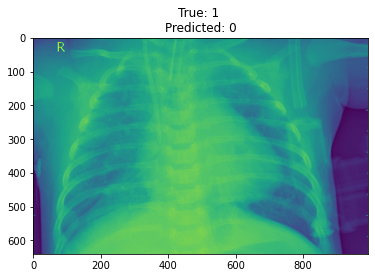

In [107]:
plt.imshow(plt.imread(test_df.Filepath.iloc[1]))
plt.title(f"True: {test_df.Label.iloc[1]} \nPredicted: {pred[1]}")
plt.show()

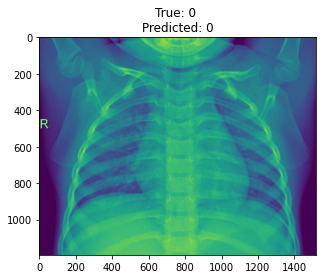

In [108]:
plt.imshow(plt.imread(test_df.Filepath.iloc[7]))
plt.title(f"True: {test_df.Label.iloc[7]} \nPredicted: {pred[7]}")
plt.show()

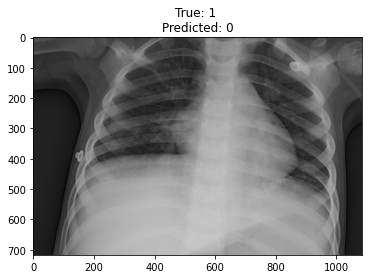

In [109]:
plt.imshow(plt.imread(test_df.Filepath.iloc[8]))
plt.title(f"True: {test_df.Label.iloc[8]} \nPredicted: {pred[8]}")
plt.show()

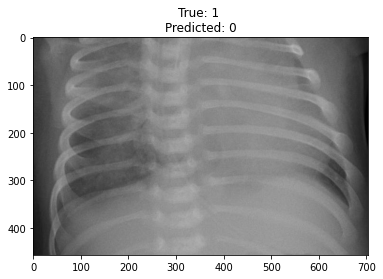

In [111]:
plt.imshow(plt.imread(test_df.Filepath.iloc[15]))
plt.title(f"True: {test_df.Label.iloc[15]} \nPredicted: {pred[1]}")
plt.show()

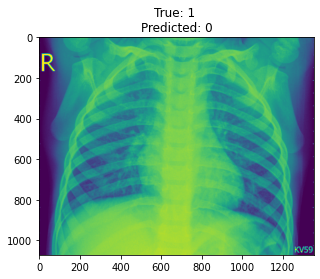

In [112]:
plt.imshow(plt.imread(test_df.Filepath.iloc[3]))
plt.title(f"True: {test_df.Label.iloc[3]} \nPredicted: {pred[3]}")
plt.show()

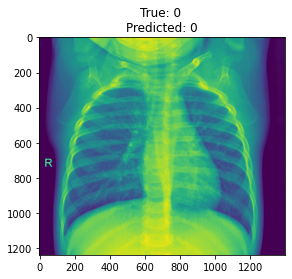

In [114]:
plt.imshow(plt.imread(test_df.Filepath.iloc[23]))
plt.title(f"True: {test_df.Label.iloc[23]} \nPredicted: {pred[2]}")
plt.show()